## Importing Required Libraries and Dataset Information

In this section, we import all the essential libraries used throughout the OCR model training process.

- **os**: Used for directory and file path operations.  
- **numpy** and **pandas**: For efficient numerical computations and structured dataset manipulation.  
- **tensorflow** and **tf_keras**: Deep learning frameworks used for building and training convolutional neural networks (CNNs).  
  > Note: `tf_keras` is used instead of `tensorflow.keras` due to version conflicts experienced with the TensorFlow installation in the environment.  
- **scikit-learn (sklearn)**: For data preprocessing tasks like splitting the dataset and encoding labels.  
- **cv2 (OpenCV)**: For handling and preprocessing image data.  
- **easyocr**: An OCR (Optical Character Recognition) library used for reading text from images and evaluating model performance.  
- **matplotlib**: For visualizing images and training progress.  
- **json** and **datetime**: For result saving and timestamp logging.

The dataset used for training is publicly available on **Kaggle**:
> [Doctors Handwritten Prescription BD Dataset](https://www.kaggle.com/datasets/mamun1113/doctors-handwritten-prescription-bd-dataset)

This dataset contains images of handwritten doctor prescriptions from Bangladeshi medical sources.  
The goal is to train an OCR model that can extract and recognize handwritten text from such medical prescriptions — an essential step in automating medical record digitization and prescription analysis.


In [1]:
import os
import cv2
import json
import easyocr
import datetime
import tf_keras
import warnings

import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tf_keras import models
from tf_keras.preprocessing.image import img_to_array, load_img
from tf_keras.utils import to_categorical
from tf_keras.models import Sequential
from tf_keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tf_keras.optimizers import Adam
from tf_keras.models import load_model

warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

In [2]:
df=pd.read_csv("../data/Doctors_Handwritten_PBD_dataset/Training/training_labels.csv")
df.head()

,IMAGE,MEDICINE_NAME,GENERIC_NAME
0,0.png,Aceta,Paracetamol
1,1.png,Aceta,Paracetamol
2,2.png,Aceta,Paracetamol
3,3.png,Aceta,Paracetamol
4,4.png,Aceta,Paracetamol


In [3]:
# import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Num GPUs Available:  0


In [4]:
print(df.columns)

Index(['IMAGE', 'MEDICINE_NAME', 'GENERIC_NAME'], dtype='object')


## Data Preparation, Model Training, and Evaluation

In this section, we perform the **complete OCR model training workflow** — from reading the dataset to saving the trained model.

This model serves as the foundation for the **Optical Character Recognition (OCR) system**, enabling the automatic extraction and classification of handwritten medicine names from doctor prescriptions.


In [5]:

# Define the paths to the images and labels
image_folder = r'..\data\Doctors_Handwritten_PBD_dataset\Training\training_words'
label_file = r'..\data\Doctors_Handwritten_PBD_dataset\Training\training_labels.csv'

# Load labels
labels_df = pd.read_csv(label_file)

# Print column names to verify
print("Column names in the CSV file:", labels_df.columns)

# Initialize lists for images and labels
images = []
labels = []

# Correct the column names based on the printed output
filename_col = 'IMAGE'
label_col = 'MEDICINE_NAME'


# Check if the specified columns exist
if filename_col not in labels_df.columns or label_col not in labels_df.columns:
    raise ValueError(f"Specified columns '{filename_col}' or '{label_col}' not found in the CSV file.")

# Load images and their corresponding labels
for index, row in labels_df.iterrows():
    img_path = os.path.join(image_folder, row[filename_col])
    img = load_img(img_path, target_size=(64, 64))  # Resize to a fixed size
    img = img_to_array(img)
    images.append(img)
    labels.append(row[label_col])

# Convert lists to numpy arrays
images = np.array(images, dtype="float") / 255.0  # Normalize pixel values
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded, num_classes=78)  # 78 classes

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Build the model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(78, activation='softmax'))  # 78 classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Save the model
model.save('models/prescription_classification_model.h5')


Column names in the CSV file: Index(['IMAGE', 'MEDICINE_NAME', 'GENERIC_NAME'], dtype='object')


Epoch 1/20


78/78 [==============================] - 6s 60ms/step - loss: 4.3663 - accuracy: 0.0092 - val_loss: 4.3581 - val_accuracy: 0.0096
Epoch 2/20
78/78 [==============================] - 4s 51ms/step - loss: 4.3406 - accuracy: 0.0148 - val_loss: 4.2703 - val_accuracy: 0.0192
Epoch 3/20
78/78 [==============================] - 4s 52ms/step - loss: 4.0849 - accuracy: 0.0577 - val_loss: 3.7249 - val_accuracy: 0.1699
Epoch 4/20
78/78 [==============================] - 4s 50ms/step - loss: 3.2139 - accuracy: 0.2256 - val_loss: 2.5307 - val_accuracy: 0.3846
Epoch 5/20
78/78 [==============================] - 4s 50ms/step - loss: 2.3173 - accuracy: 0.4087 - val_loss: 2.0094 - val_accuracy: 0.5000
Epoch 6/20
78/78 [==============================] - 4s 49ms/step - loss: 1.7703 - accuracy: 0.5300 - val_loss: 1.7062 - val_accuracy: 0.5625
Epoch 7/20
78/78 [==============================] - 4s

c:\Users\sanja\AppData\Local\Programs\Python\Python312\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Image Data Loading, Model Training, and Evaluation

This section performs the complete workflow for preparing the dataset, building a Convolutional Neural Network (CNN), training it to recognize handwritten medicine names, and evaluating its performance.


The model is trained for **20 epochs** with a batch size of **32**, using a validation split to monitor performance on unseen data during training.

---

### Model Evaluation and Saving
After training:
- The model is evaluated on the test set to calculate **accuracy**.  
- The trained model is then saved in the **modern `.keras` format**, ensuring better compatibility with TensorFlow 2.x and Keras 3.x environments.

This trained CNN forms the **foundation of the OCR system**, enabling the automated recognition of handwritten medicine names from scanned doctor prescriptions.


In [6]:

# Define the paths to the images and labels
image_folder = r'..\data\Doctors_Handwritten_PBD_dataset\Training\training_words'
label_file = r'..\data\Doctors_Handwritten_PBD_dataset\Training\training_labels.csv'

# Load labels
labels_df = pd.read_csv(label_file)

# Column names in the CSV file
filename_col = 'IMAGE'
label_col = 'MEDICINE_NAME'

# Initialize lists for images and labels
images = []
labels = []

# Load images and their corresponding labels
for index, row in labels_df.iterrows():
    img_path = os.path.join(image_folder, row[filename_col])
    img = load_img(img_path, target_size=(64, 64))  # Resize to a fixed size
    img = img_to_array(img)
    images.append(img)
    labels.append(row[label_col])

# Convert lists to numpy arrays
images = np.array(images, dtype="float") / 255.0  # Normalize pixel values
labels = np.array(labels)

# Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded, num_classes=78)  # 78 classes

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels_categorical, test_size=0.2, random_state=42)

# Build the model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(78, activation='softmax'))  # 78 classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Save the model in the newer format
model.save('models/prescription_classification_model.keras')


Epoch 1/20
78/78 [==============================] - 5s 55ms/step - loss: 4.3634 - accuracy: 0.0132 - val_loss: 4.3315 - val_accuracy: 0.0224
Epoch 2/20
78/78 [==============================] - 4s 52ms/step - loss: 4.2325 - accuracy: 0.0244 - val_loss: 4.1664 - val_accuracy: 0.0641
Epoch 3/20
78/78 [==============================] - 4s 55ms/step - loss: 3.9456 - accuracy: 0.0853 - val_loss: 3.6401 - val_accuracy: 0.1426
Epoch 4/20
78/78 [==============================] - 4s 57ms/step - loss: 3.1473 - accuracy: 0.2404 - val_loss: 2.6283 - val_accuracy: 0.4038
Epoch 5/20
78/78 [==============================] - 5s 60ms/step - loss: 2.1921 - accuracy: 0.4395 - val_loss: 2.1232 - val_accuracy: 0.5080
Epoch 6/20
78/78 [==============================] - 5s 58ms/step - loss: 1.5840 - accuracy: 0.5797 - val_loss: 1.6450 - val_accuracy: 0.6010
Epoch 7/20
78/78 [==============================] - 4s 57ms/step - loss: 1.1112 - accuracy: 0.6891 - val_loss: 1.5727 - val_accuracy: 0.6026
Epoch 8/20
78

## Model Testing and Evaluation

In this step, the trained model is tested using a separate dataset to evaluate its accuracy and performance. The test images and their labels are loaded from the specified directory, resized to 64×64 pixels, and normalized. Labels are encoded using `LabelEncoder` and converted to categorical format with 78 classes. The saved model (`prescription_classification_model.keras`) is then loaded and evaluated on the test data to calculate accuracy. Finally, predictions are made to generate a classification report and confusion matrix, which help analyze how well the model recognizes different handwritten medicine names.


In [12]:
# Define the paths to the test images and labels
test_image_folder = r'..\data\Doctors_Handwritten_PBD_dataset\Testing\testing_words'
test_label_file = r'..\data\Doctors_Handwritten_PBD_dataset\Testing\testing_labels.csv'

# Load test labels
test_labels_df = pd.read_csv(test_label_file)

# Column names in the CSV file
filename_col = 'IMAGE'
label_col = 'MEDICINE_NAME'

# Initialize lists for test images and labels
test_images = []
test_labels = []

# Load test images and their corresponding labels
for index, row in test_labels_df.iterrows():
    img_path = os.path.join(test_image_folder, row[filename_col])
    img = load_img(img_path, target_size=(64, 64))  # Resize to a fixed size
    img = img_to_array(img)
    test_images.append(img)
    test_labels.append(row[label_col])

# Convert lists to numpy arrays
test_images = np.array(test_images, dtype="float") / 255.0  # Normalize pixel values
test_labels = np.array(test_labels)

# Encode test labels
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)
test_labels_categorical = tf_keras.utils.to_categorical(test_labels_encoded, num_classes=78)  # 78 classes

# Load the trained model
model = load_model('models/prescription_classification_model.keras')

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_images, test_labels_categorical)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Optionally: Predict and show a confusion matrix


# Predict the classes
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels_categorical, axis=1)

# Generate classification report
print(classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_))

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)


25/25 [==============================] - 1s 17ms/step - loss: 3.1999 - accuracy: 0.5410
Test Accuracy: 54.10%
25/25 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

         Ace       0.67      0.60      0.63        10
       Aceta       0.47      0.90      0.62        10
     Alatrol       0.67      0.20      0.31        10
      Amodis       0.17      0.10      0.12        10
     Atrizin       0.50      0.50      0.50        10
      Axodin       0.40      0.80      0.53        10
          Az       0.67      0.80      0.73        10
  Azithrocin       0.86      0.60      0.71        10
       Azyth       0.58      0.70      0.64        10
      Bacaid       0.50      0.90      0.64        10
    Backtone       0.75      0.30      0.43        10
    Baclofen       0.69      0.90      0.78        10
      Baclon       0.57      0.40      0.47        10
      Bacmax       0.86      0.60      0.71        10
       Beklo       0.67  

## Function-Based Model Evaluation

This step defines two reusable functions for evaluating the trained OCR model. The first function, `load_and_prepare_test_data`, loads the test images and labels, resizes them to 64×64 pixels, normalizes the pixel values, and encodes the labels into categorical form. The second function, `evaluate_model`, lo_


In [13]:
def load_and_prepare_test_data(test_image_folder, test_label_file, target_size=(64, 64)):
    # Load test labels
    test_labels_df = pd.read_csv(test_label_file)

    # Column names in the CSV file
    filename_col = 'IMAGE'
    label_col = 'MEDICINE_NAME'

    # Initialize lists for test images and labels
    test_images = []
    test_labels = []

    # Load test images and their corresponding labels
    for index, row in test_labels_df.iterrows():
        img_path = os.path.join(test_image_folder, row[filename_col])
        img = load_img(img_path, target_size=target_size)  # Resize to a fixed size
        img = img_to_array(img)
        test_images.append(img)
        test_labels.append(row[label_col])

    # Convert lists to numpy arrays
    test_images = np.array(test_images, dtype="float") / 255.0  # Normalize pixel values
    test_labels = np.array(test_labels)

    # Encode test labels
    label_encoder = LabelEncoder()
    test_labels_encoded = label_encoder.fit_transform(test_labels)
    test_labels_categorical = tf_keras.utils.to_categorical(test_labels_encoded, num_classes=len(label_encoder.classes_))

    return test_images, test_labels_categorical, label_encoder

def evaluate_model(model_path, test_images, test_labels_categorical, label_encoder):
    model = load_model(model_path)

    # Evaluate the model on the test data
    loss, accuracy = model.evaluate(test_images, test_labels_categorical)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

    # Predict the classes
    predictions = model.predict(test_images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels_categorical, axis=1)

    print(classification_report(true_classes, predicted_classes, target_names=label_encoder.classes_))

    # Generate confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    print("Confusion Matrix:")
    print(conf_matrix)

# Paths to your test data
test_image_folder = r'..\data\Doctors_Handwritten_PBD_dataset\Testing\testing_words'
test_label_file = r'..\data\Doctors_Handwritten_PBD_dataset\Testing\testing_labels.csv'
model_path = 'models/prescription_classification_model.keras'

# Load and prepare test data
test_images, test_labels_categorical, label_encoder = load_and_prepare_test_data(test_image_folder, test_label_file)

# Evaluate the model on the new test data
evaluate_model(model_path, test_images, test_labels_categorical, label_encoder)


25/25 [==============================] - 1s 17ms/step - loss: 3.1999 - accuracy: 0.5410
Test Accuracy: 54.10%
25/25 [==============================] - 0s 15ms/step
              precision    recall  f1-score   support

         Ace       0.67      0.60      0.63        10
       Aceta       0.47      0.90      0.62        10
     Alatrol       0.67      0.20      0.31        10
      Amodis       0.17      0.10      0.12        10
     Atrizin       0.50      0.50      0.50        10
      Axodin       0.40      0.80      0.53        10
          Az       0.67      0.80      0.73        10
  Azithrocin       0.86      0.60      0.71        10
       Azyth       0.58      0.70      0.64        10
      Bacaid       0.50      0.90      0.64        10
    Backtone       0.75      0.30      0.43        10
    Baclofen       0.69      0.90      0.78        10
      Baclon       0.57      0.40      0.47        10
      Bacmax       0.86      0.60      0.71        10
       Beklo       0.67  

In [14]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


20/20 [==============================] - 0s 17ms/step - loss: 1.5036 - accuracy: 0.7003
Test Accuracy: 70.03%


In [15]:
# Save the model
model.save('models/prescription_classification_model.h5')

## Prescription Image Inference and Result Saving

In this step, the trained detection and recognition models are used to analyze a new prescription image. The image is read using OpenCV, and text regions are detected with EasyOCR. Each detected crop is preprocessed and passed through the models to predict medicine names and their confidence scores. The results, including bounding boxes, OCR text, and model predictions, are printed, visualized on the image, and saved to disk as both annotated images and JSON files for further analysis. This enables end-to-end automatic extraction and classification of handwritten medicines from prescription images.


In [3]:

# Load trained models
DETECTION_MODEL_PATH = r'models\prescription_classification_model.h5'
RECOGNITION_MODEL_PATH = r'models\prescription_classification_model.keras'

detection_model = models.load_model(DETECTION_MODEL_PATH)
recognition_model = models.load_model(RECOGNITION_MODEL_PATH)

# Load class labels from JSON file
with open("models/class_labels.json", "r", encoding="utf-8") as f:
    class_labels = json.load(f)["class_labels"]

image_path = input("Enter image path: ").strip()

if not os.path.exists(image_path):
    raise FileNotFoundError(f"Image not found: {image_path}")

# EasyOCR Reader
reader = easyocr.Reader(['en'])

def preprocess_crop(crop, model):
    target_h, target_w = model.input_shape[1:3]
    resized = cv2.resize(crop, (target_w, target_h))
    normalized = resized / 255.0
    batch_input = np.expand_dims(normalized, axis=0)
    return batch_input

def decode_prediction(pred):
    class_idx = np.argmax(pred, axis=1)[0]
    conf = float(np.max(pred)) * 100.0
    if class_idx < len(class_labels):
        return class_labels[class_idx], conf
    else:
        return f"Unknown_{class_idx}", conf

def process_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Could not load image: {image_path}")
        return None, None

    # OCR detection
    results = reader.readtext(image)

    # JSON container
    results_data = {
        "image": image_path,
        "timestamp": datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "results": []
    }

    # Process each detection
    for i, (bbox, easy_text, prob) in enumerate(results):
        pts = np.array(bbox, dtype=np.int32)
        x_min, y_min = map(int, bbox[0])
        x_max, y_max = map(int, bbox[2])

        crop = image[y_min:y_max, x_min:x_max]
        if crop.size == 0:
            continue

        # Model predictions
        det_pred = detection_model.predict(preprocess_crop(crop, detection_model), verbose=0)
        rec_pred = recognition_model.predict(preprocess_crop(crop, recognition_model), verbose=0)

        det_label, det_conf = decode_prediction(det_pred)
        rec_label, rec_conf = decode_prediction(rec_pred)

        cv2.polylines(image, [pts], isClosed=True, color=(0, 255, 0), thickness=2)

        print(f"[{i+1}] OCR: {easy_text} ({prob*100:.2f}%) | "
              f"Detection: {det_label} ({det_conf:.2f}%) | "
              f"Recognition: {rec_label} ({rec_conf:.2f}%)")

        # Save results
        entry = {
            "bbox": [list(map(int, point)) for point in bbox],
            "easyocr_text": easy_text,
            "easyocr_conf": float(prob) * 100.0,
            "detection_model": det_label,
            "detection_conf": det_conf,
            "recognition_model": rec_label,
            "recognition_conf": rec_conf
        }
        results_data["results"].append(entry)

    # Save image + JSON
    timestamp = datetime.datetime.now().strftime("%m%d_%H%M%S")
    image_output_dir = r"output\test_results"
    json_output_dir = r"output\json_results"

    os.makedirs(image_output_dir, exist_ok=True)
    os.makedirs(json_output_dir, exist_ok=True)

    output_path = os.path.join(image_output_dir, f"result_{timestamp}.jpg")
    cv2.imwrite(output_path, image)
    print(f"Image saved as {output_path}")

    json_path = os.path.join(json_output_dir, f"output_{timestamp}.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(results_data, f, indent=4, ensure_ascii=False)
    print(f"JSON saved as {json_path}\n")

    return image, results_data

original_image = cv2.imread(image_path)
processed_image, results_data = process_image(image_path)


[1] OCR: Dr: RKeshwani (93.02%) | Detection: Ace (8.31%) | Recognition: Ace (8.31%)
[2] OCR: Alotlo No (13.32%) | Detection: Azyth (6.17%) | Recognition: Azyth (6.17%)
[3] OCR: Vnam1"e (0.29%) | Detection: Backtone (7.49%) | Recognition: Backtone (7.49%)
[4] OCR: MA08 , PGLHS (Chatsehsogy} (0.52%) | Detection: Disopan (8.78%) | Recognition: Disopan (8.78%)
[5] OCR: Cind (6.46%) | Detection: Exium (4.61%) | Recognition: Exium (4.61%)
[6] OCR: 07uruindo (0.07%) | Detection: Rhinil (2.10%) | Recognition: Rhinil (2.10%)
[7] OCR: V (1.58%) | Detection: Montene (5.60%) | Recognition: Montene (5.60%)
[8] OCR: ae (1.27%) | Detection: Odmon (6.12%) | Recognition: Odmon (6.12%)
[9] OCR: Fu (0.30%) | Detection: Lucan-R (6.13%) | Recognition: Lucan-R (6.13%)
[10] OCR: Gcuetal Fsicim (14.72%) | Detection: Montene (4.89%) | Recognition: Montene (4.89%)
[11] OCR: Duabatolorist (17.74%) | Detection: Montene (7.86%) | Recognition: Montene (7.86%)
[12] OCR: Aue (1.02%) | Detection: Provair (5.85%) | Rec

## Displaying Results and Extracting Final Words

This function visualizes the original prescription image alongside the processed image with detected text regions. It also collects the most confident predictions from EasyOCR, detection, and recognition models for each detected word, and prints them separately as the final detected words with their confidence scores. This allows clear inspection of both the annotated image and the extracted text results.


In [4]:

def show_final_results(original_image, processed_image, results_data):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    # ---- Left: Input Image ----
    axes[0].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # ---- Right: Output Image ----
    axes[1].imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Output with Detections")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    # ---- Collect Final Detected Words (print outside plot) ----
    final_detected_words = []
    for res in results_data["results"]:
        candidates = [
            (res["easyocr_text"], res["easyocr_conf"]),
            (res["detection_model"], res["detection_conf"]),
            (res["recognition_model"], res["recognition_conf"])
        ]
        best_word, best_conf = max(candidates, key=lambda x: x[1])
        final_detected_words.append((best_word, best_conf))

    print("\n=== Final Detected Words ===")
    for word, conf in final_detected_words:
        print(f"{word} ({conf:.2f}%)")

    return final_detected_words


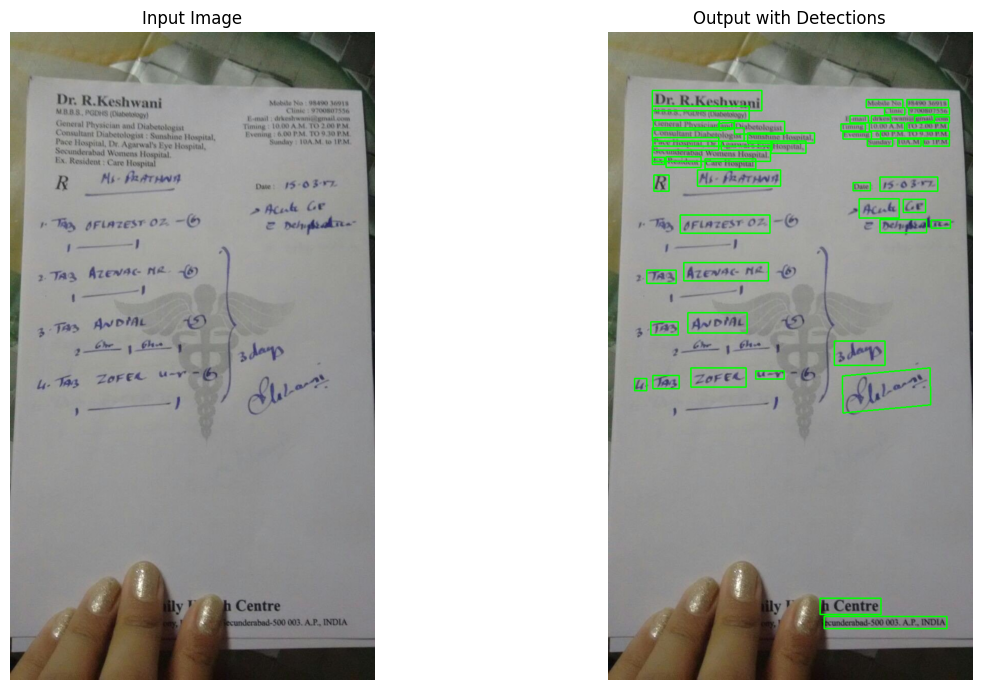


=== Final Detected Words ===
Dr: RKeshwani (93.02%)
Alotlo No (13.32%)
Backtone (7.49%)
Disopan (8.78%)
Cind (6.46%)
Rhinil (2.10%)
Montene (5.60%)
Odmon (6.12%)
Lucan-R (6.13%)
Gcuetal Fsicim (14.72%)
Duabatolorist (17.74%)
Provair (5.85%)
Bacaid (6.20%)
Cetisoft (6.05%)
Consultant Duabetoloxit (27.28%)
Montene (12.76%)
Provair (6.22%)
Odmon (4.94%)
Disopan (20.03%)
Montene (13.35%)
Backtone (7.99%)
Cetisoft (9.19%)
Ketotab (4.59%)
Monas (20.46%)
Seurlerated Wouens Hosptal. (10.81%)
Provair (14.83%)
Resddcut (33.07%)
Cata Hosp"al (22.13%)
R (100.00%)
Montene (9.87%)
Date (12.80%)
"3 0} (16.93%)
Ack (23.10%)
G (80.59%)
Ofiazest 02 (27.16%)
Dinafex (27.81%)
Azithrocin (9.41%)
JA> (19.03%)
Lucan-R (9.05%)
T4> (60.17%)
Avdtal (44.00%)
skp (56.12%)
ZofeL (42.72%)
Renova (16.33%)
Li (29.05%)
a} (48.83%)
h Centre (97.43%)
rcunderbad-SO0 003.AP_INDIA (18.64%)
Cetisoft (3.46%)
Esonix (31.73%)
(u~~ (12.16%)


In [5]:
final_detected_words = show_final_results(original_image, processed_image, results_data)